In [1]:
# (1)
# finalize this document / ORGANIZED CHECK

# (1b)
# check with these clusters how the inventory trend looks

# (2)
# everytime i fit model, different performance! ??? should i do something, like run many and keep the best?
# ? shall i keep versions and with and without isomap? and use performance metric to compare them?
# do ensemble to the gaussian model that I will choose?

# (3)
# look for the prophet- time series

# (3b)
# make predictions with the model without clustering and then with clustering
# and compare :')

# (4)
# supervised ML for the rest of orders without customer ID

# (5)
# how to make a pipeline of all these steps??
# and ptactically, to be able to run, when there are new data
# and visually to explain in presentetion

# note:
# i need to see how to handle the fact that some clusters will have different amount of samples,
# the retail has wayyy more clients
# should i do some techniques to make the amounts more equal? 

# Importing libraries and cleaned dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors

import functions
from functions import feat_eng,scaling_data,k_means_model,dbscan_model,scatter_plot,hdbscan_model,gm_model,mshift_model,outlier_scaling,outliers_clipping_STD


import hdbscan

Importing plotly failed. Interactive plots will not work.


In [3]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [4]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK and filtering the dataset to include only sales related to products.

In [5]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df_fltrd = df[df.StockCode != 'OTHER']

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df_fltrd = df_fltrd[df_fltrd.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df_fltrd.dropna(subset='CustomerID', inplace=True)

# Creating new column with the total price for each item 
df_fltrd['TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

# Feature Engineering

**Total Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers: using the total quantity purchased by each customer as a feature.

**Total Price:** Wholesale customers typically spend more money on their purchases compared to retail customers: using the total price of orders can help distinguish between the two groups.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. 

**Total Orders:** Wholesale customers are likely to place more orders than retail customers. To calculate the total number of orders for each customer over a given time period. *Not sure if I will use that for the final model.*

For my ML model I will try clustering algorithms such as K-means, DBSCAN, HDBSCAN, or hierarchical clustering. I will do feature engineering, and conduct an EDA to see my data, and experiment and decide on the best model.

In [6]:
# Function defined at the functions.py
cust = feat_eng(df_fltrd)
cust.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,TotalOrders
CustomerID,,,,,
12346,74215,92768.75,74215.00,92768.75,1
12747,1275,4722.51,12.38,429.32,11
12748,25051,46021.25,5.87,223.40,206
12749,1470,4043.94,7.42,808.79,5
12820,722,938.94,12.24,234.74,4


# EDA

Based on the following analyis I see that I have many outliers and noise in my data. These are the conclusions drawn from this 'EDA' section:

There is an important decision to be made. I see that I have two types of outliers/ noise.
- One comes from the two invoices with number '581483','541431' (two outliers). The Quantity and value of these invoices is huge, not comparable at all with the rest of the 19962 invoices. Also, these 2 invoices, one is from a client that ordered only once (that very big order of only one item) and the other client had this huge order and only two more items at another time. That makes me think that they are not really repeated wholesale customers, and are stand-alone cases that since they differ so much for the model accuracy can be disadvantage.
- Then when I see my data without these two, I can see the noise around my data. This second type of outliers they still need to be treated, but their scale is more comparable to the rest of the data.

I am going to do outlier clipping for the noise at my data, but when I do it without removing the 2 outliers first, the dataset is still very noisy and I don't trust that the trained ML model can be accurate enough.
For that reason I decided in the next section of the notebook 'Outliers' to treat these two types differently.

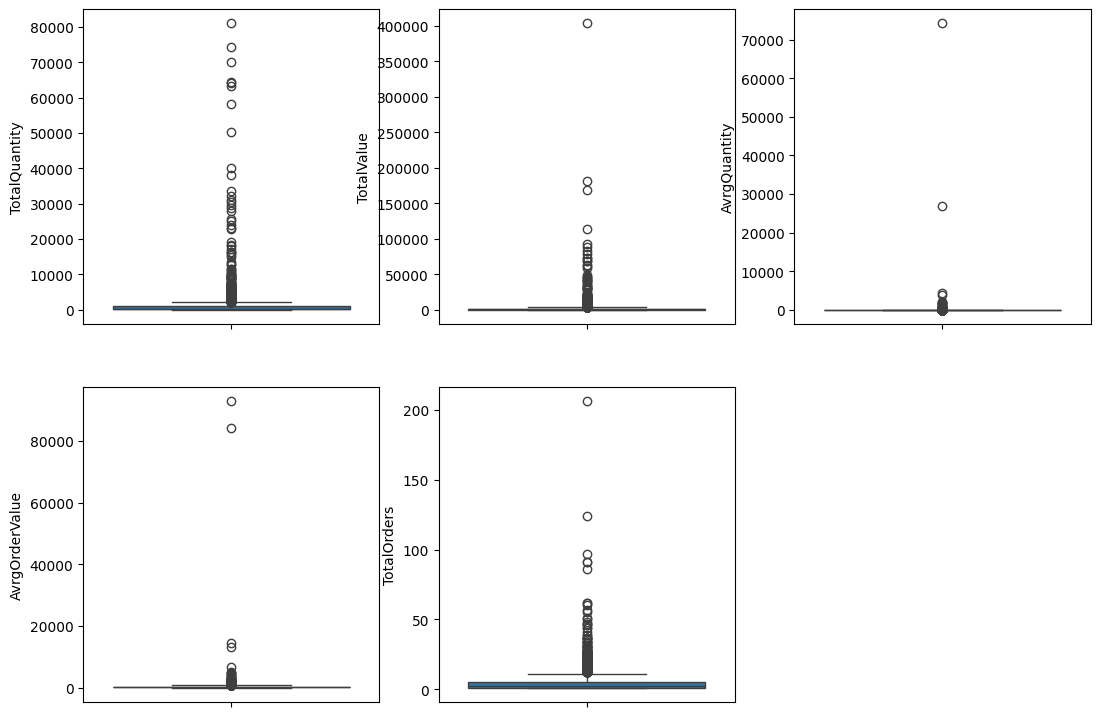

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13, 9))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[0, 2]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 0]) 
sns.boxplot(data=cust['TotalOrders'], ax=ax[1, 1]) 

# Remove the empty subplot
fig.delaxes(ax[1, 2])

plt.show()

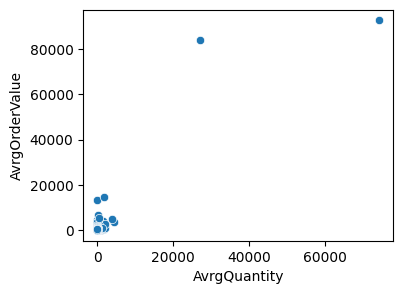

In [8]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

In [9]:
# Looking into the two big outliers
df[df.InvoiceNo.isin(['581483','541431'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [10]:
df[df.CustomerID.isin([12346,16446])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
188029,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446,United Kingdom
188030,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


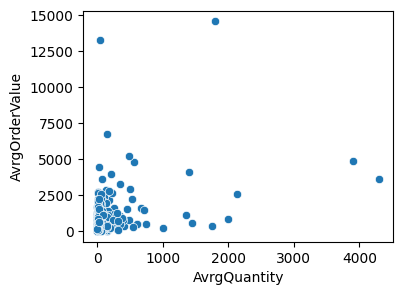

In [11]:
# Checking the scatterplots without the two big outliers, to see my data a bit more clearly
# I am doing he same process as above, using the function I defined
cust_fltrd = feat_eng(df_fltrd[~df_fltrd.InvoiceNo.isin(['581483','541431'])])

# Plotting
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_fltrd, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

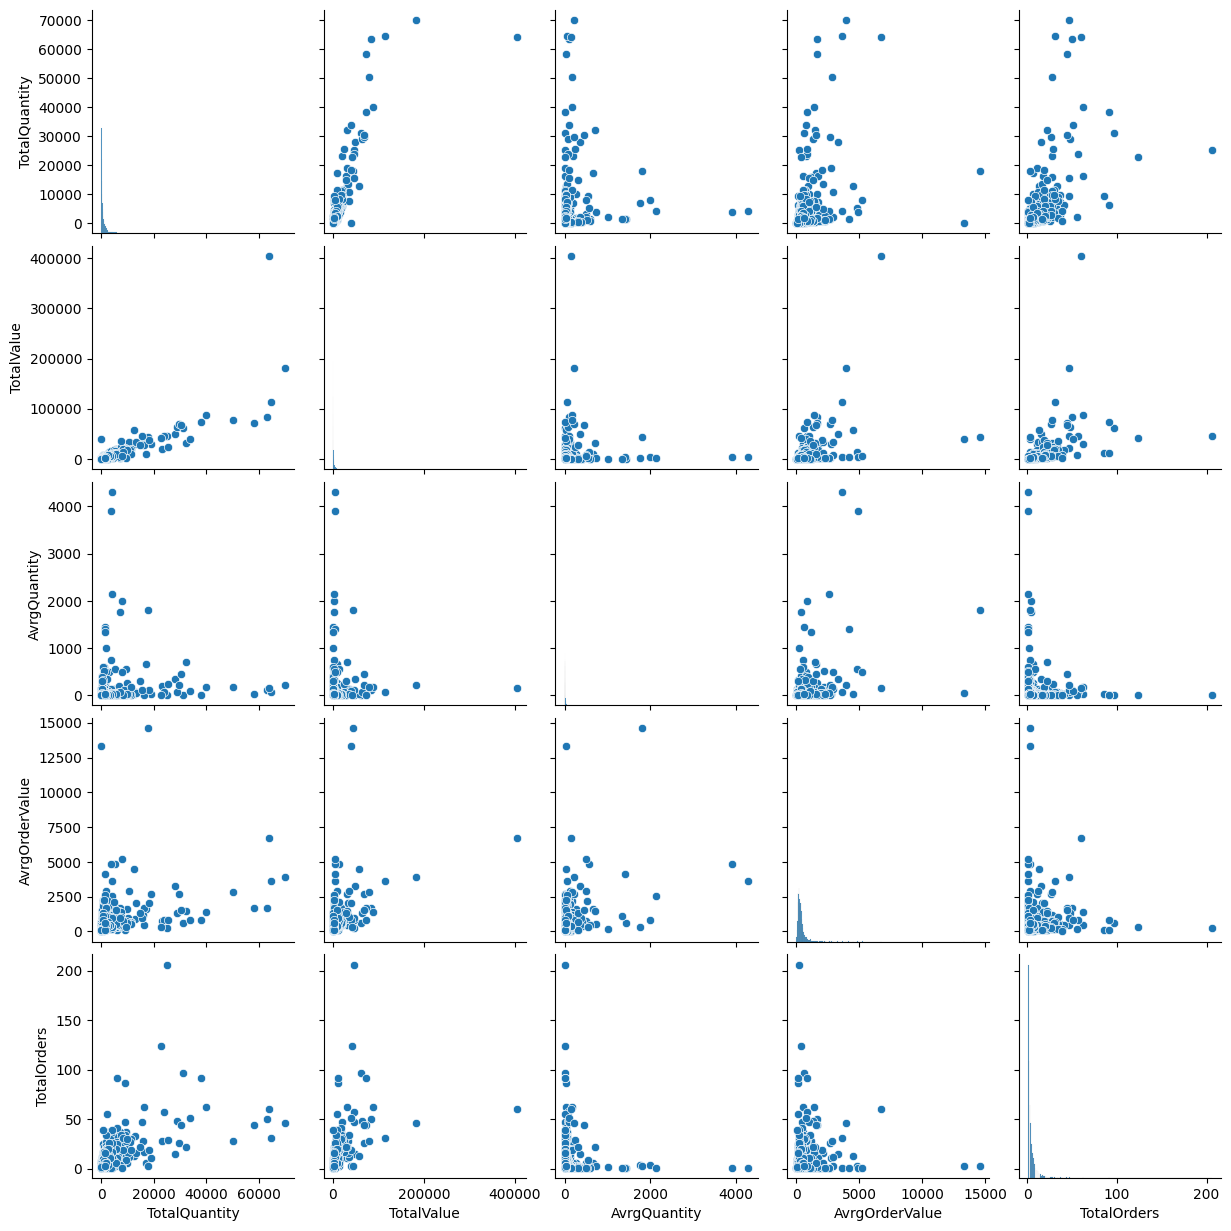

In [12]:
sns.pairplot(cust_fltrd)

# Outliers: data normalization

Based on the noise and outliers that I identified in the previous section, I am going to implement two different approaches for the two types of outliers.
- to the two outliers with the huge difference in scale, I am going to do scaling to a range, scaling them to highest next value (after these two).
- then after completing that, I will do outlier clipping for the rest of the outliers/ noice. I trust that in this way my model will have better scale and will have more accuracy, and at the same time, since I only want two clusters (wholesale and retail) these outliers/noise will still be the highest values in my dataset, and they will most probably be incorporated into the cluster of the wholesale customers. For that I will use the Stardard Deciation method, by z-score to +-3σ (σ is the standard deviation).

Helpful aricle:
https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=Z%2Dscore%20is%20a%20variation,extreme%20that%20you%20need%20clipping.

In [13]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df_fltrd_sc = outlier_scaling(df_fltrd.copy())

In [14]:
# Creating the updated customer dataframe
cust_norm = feat_eng(df_fltrd_sc)

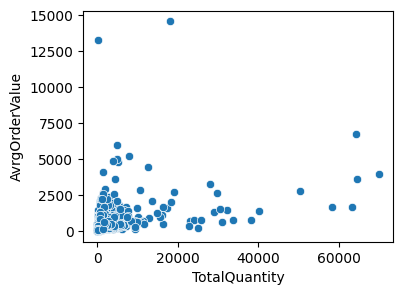

In [15]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_norm, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

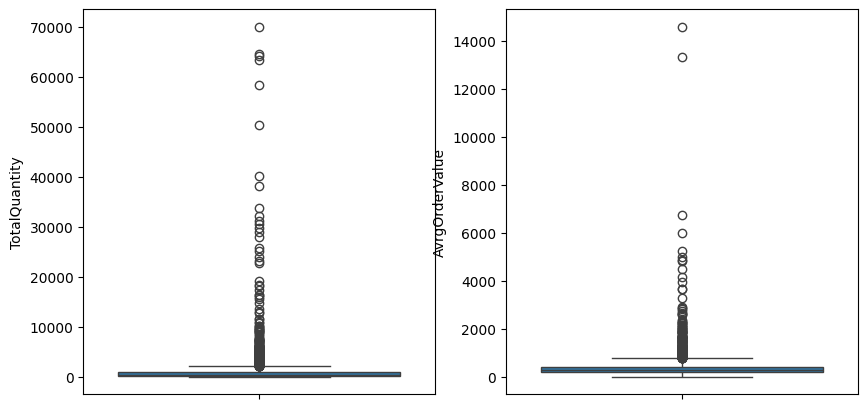

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.boxplot(data=cust_norm['TotalQuantity'], ax=ax[0]) 
sns.boxplot(data=cust_norm['AvrgOrderValue'], ax=ax[1]) 

plt.show()

In [17]:
cust_norm.columns

Index(['TotalQuantity', 'TotalValue', 'AvrgQuantity', 'AvrgOrderValue',
       'TotalOrders'],
      dtype='object')

In [18]:
# Creating a copy of the dataframe for the clipping
cust_norm_clip = cust_norm.copy()

In [20]:
# Clipping outliers witht the Standard Deviation Method, with the custom function
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'TotalQuantity')
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'TotalValue')
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'AvrgQuantity')
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'AvrgOrderValue')
cust_norm_clip = outliers_clipping_STD(cust_norm_clip,'TotalOrders')

Instances that needed outlier clipping:  34 , out of total instances:  3917
Instances that needed outlier clipping:  32 , out of total instances:  3917
Instances that needed outlier clipping:  23 , out of total instances:  3917
Instances that needed outlier clipping:  44 , out of total instances:  3917
Instances that needed outlier clipping:  50 , out of total instances:  3917


In [21]:
# from domain knowledge I was debating if to do total orders. Given also the outliers, I will not use it
cust_norm_clip.drop('TotalOrders',axis=1,inplace=True)

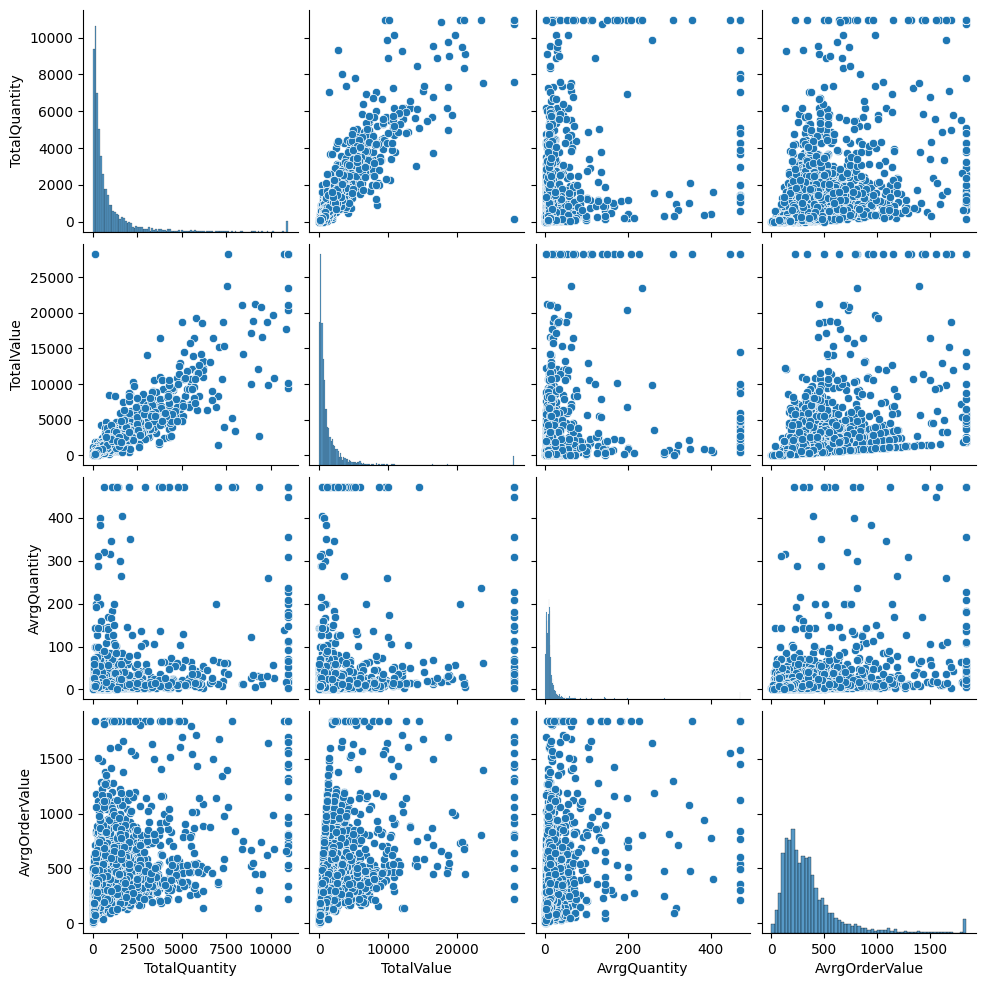

In [23]:
# looking much better
sns.pairplot(cust_norm_clip)

# Scaling data

Normalization rescales the data to have values between 0 and 1, while standardization rescales the data to have a mean of 0 and a standard deviation of 1. There are various methods to normalize or standardize the data, such as min-max scaling, z-score scaling, or log transformation. Here I tried the first two, but I will choose the standardization (z-score scaling) that is less sensitive to outliers than min-max scaling (where scale is heavily influenced by the extreme maximum and minimum values).

### StandardScaler

Standarization: the values are transfomed to end up with mean = 0 and std = 0.

$$z = \frac{(x-mean(x))}{\sigma}$$

In [24]:
# Scaling the data, function defined at functions.py
cust_norm_clip_stndrd = scaling_data(cust_norm_clip)

# Dimensionality reduction

Non-linear dimensionality reduction through Isometric Mapping.

In [25]:
# Create an Isomap object with the desired number of components
isomap = Isomap(n_neighbors=5, n_components=2)

# Fit the Isomap model to the data and transform it to the lower-dimensional space
cust_norm_clip_stndrd_reduced = isomap.fit_transform(cust_norm_clip_stndrd)

In [26]:
cust_norm_clip_stndrd_reduced = pd.DataFrame(cust_norm_clip_stndrd_reduced, columns = ['Component 1', 'Component 2'], 
                                             index=cust_norm_clip_stndrd.index)
cust_norm_clip_stndrd_reduced.head()

,Component 1,Component 2
CustomerID,,
12346,12.442217,16.067094
12747,1.307553,-0.701091
12748,15.738592,-2.993549
12749,1.333805,-0.103321
12820,-0.297232,-0.082926


# Elbow Method, for the optimal number of clusters

I am doing the Elbow Method (most commonly used with clustering algorithms like K-means) to see how the inertia looks depending on the number of clusters.

From the result I can see that doing 4 cluster would be a good option.

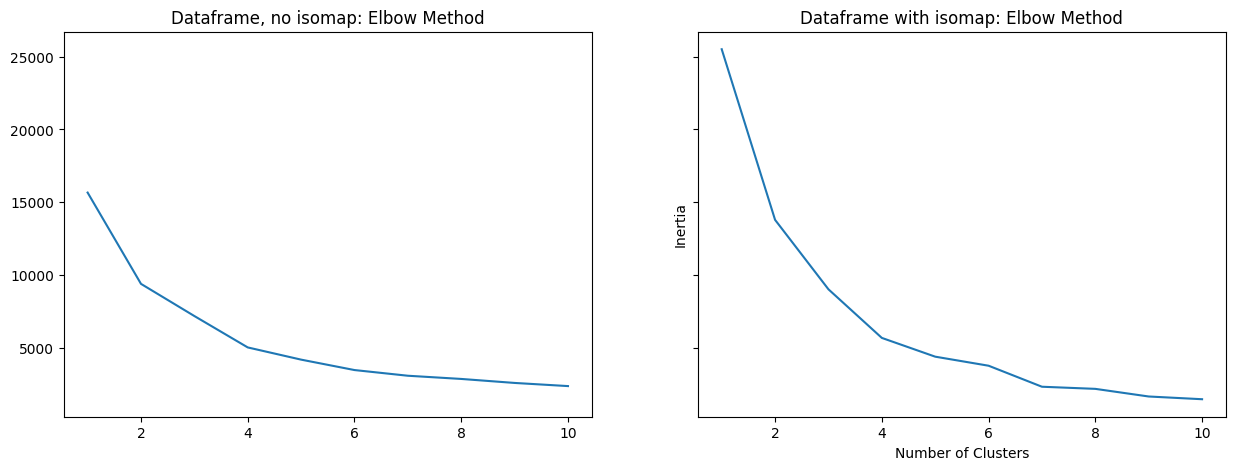

In [27]:
# Finding the optimal number of clusters, looking at my data with reduced dimensionality and without
# these lists are also used later in the code
list_df = [cust_norm_clip_stndrd, cust_norm_clip_stndrd_reduced]
list_df_names = ['Dataframe, no isomap', 'Dataframe with isomap']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# Checking the plot for 1-10 clusters
for i, (model, model_name) in enumerate(zip(list_df,list_df_names)):
    inertias = []
    for j in range(1,11):
        kmeans = KMeans(n_clusters=j)
        kmeans.fit(model)
        inertias.append(kmeans.inertia_)
    ax[i].plot(range(1,11), inertias)
    ax[i].set_title(f'{model_name}: Elbow Method')
    

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 4 clusters seems the best for both models

# Optimal Value for Epsilon (EPS)

Will be used for the DBSCAn model.
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc          

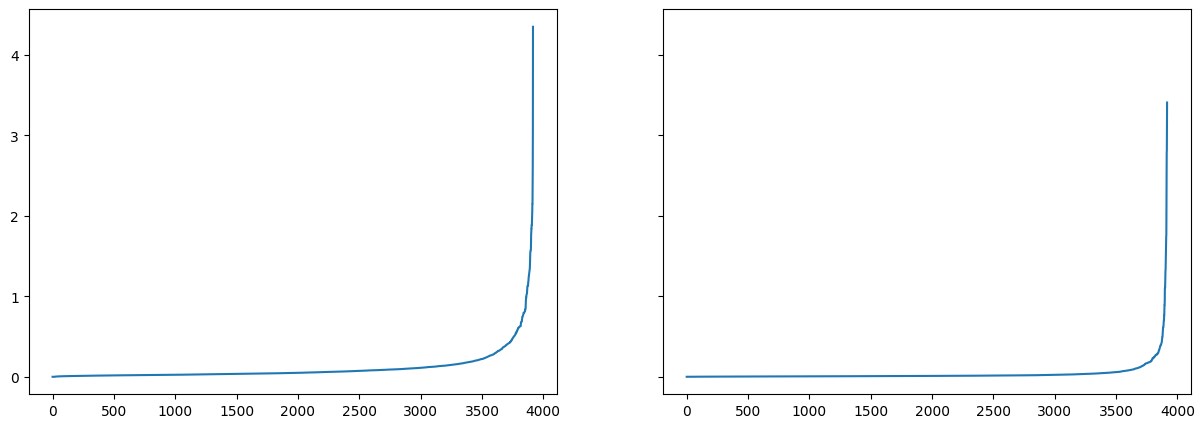

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# Checking the plot for 1-10 clusters
for i, model in enumerate(list_df):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(model)
    distances, indices = nbrs.kneighbors(model)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    ax[i].plot(distances)

plt.show()

It seems we need a very low Epsilon value close to 0.2.

# Building models

Helpful resource:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Models evaluation

While training the models I will use 4 main parameters to compare the models:
- **Silhouette Coefficient:** higher Silhouette Score suggests denser, well-separated clusters
- **Calinski-Harabasz Index:** higher Calinski-Harabasz Index suggests better cluster separation
- **Davies-Bouldin Index:** lower Davies-Bouldin Index indicates better cluster quality
- **Count of customers per cluster:** more evenly dictributed customers per cluster will be better for training models in the future
- **Visual inspection:** checking how the clusters are defined at scatterplot

Helpful resource: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

## Clustering with K-Means

After looking at my EDA, I conclude that K-Means will not be a good model for my dataset. I will test it however anywyay.

K-means can be quite sensitive to oultiers and has an intrinsic preference for globular clusters.

Kmeans silhouette coefficient:  0.6041
Kmeans Calinski-Harabasz Index:  3071.1618
Kmeans Davies-Bouldin Index:  0.8330
Label: 1, Percentage total customers: 1.81%
Label: 2, Percentage total customers: 0.92%
Label: 0, Percentage total customers: 18.25%
Label: 3, Percentage total customers: 79.01%


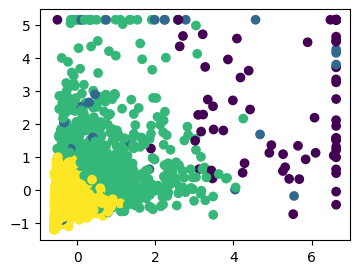

In [29]:
# Choosing 4 clusters, using function defined in the functions.py
cust_kmeans = k_means_model(cust_norm_clip_stndrd,4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans['TotalQuantity'], y=cust_kmeans['AvrgOrderValue'], c=cust_kmeans['kmeans_labels'])
plt.show()

### Clustering with K-means - Less features

Kmeans silhouette coefficient:  0.7465
Kmeans Calinski-Harabasz Index:  4574.5728
Kmeans Davies-Bouldin Index:  0.7014
Label: 2, Percentage total customers: 76.69%
Label: 0, Percentage total customers: 2.27%
Label: 1, Percentage total customers: 0.97%
Label: 3, Percentage total customers: 20.07%


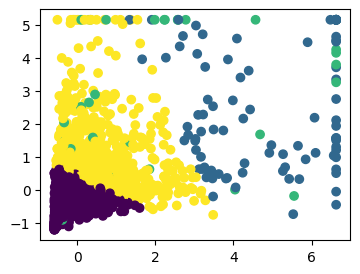

In [30]:
# 4 clusters, 3 features, using function defined in the functions.py
cust_kmeans2= k_means_model(cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']],4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans2['TotalQuantity'], y=cust_kmeans2['AvrgOrderValue'], c=cust_kmeans2['kmeans_labels'])
plt.show()

### Clustering with K-means - dimensionality reduction

Kmeans silhouette coefficient:  0.7410
Kmeans Calinski-Harabasz Index:  4956.2627
Kmeans Davies-Bouldin Index:  0.5559
Label: 3, Percentage total customers: 86.55%
Label: 2, Percentage total customers: 1.33%
Label: 1, Percentage total customers: 11.41%
Label: 0, Percentage total customers: 0.71%


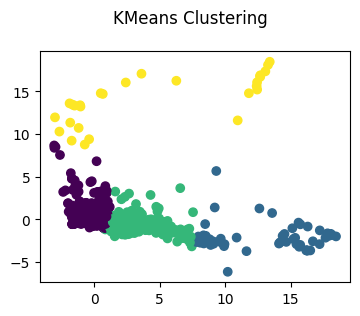

In [31]:
# using the dataframe with the isomap applied
# 4 clusters, using function defined in the functions.py
cust_kmeans3= k_means_model(cust_norm_clip_stndrd_reduced,4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_kmeans3['Component 1'], y=cust_kmeans3['Component 2'], c=cust_kmeans3['kmeans_labels'])
plt.suptitle("KMeans Clustering", y=1.02)
plt.savefig("../images/kmeans.png", bbox_inches='tight')
plt.show()

## Clustering with DBSCAN

A density-based clustering algorithm. DBSCAN tends to fall short of identifying clusters with non-uniform density.

DBSCAN silhouette coefficient:  0.5804
DBSCAN Calinski-Harabasz Index:  1650.3313
DBSCAN Davies-Bouldin Index:  1.1875
Label: -1, Percentage total customers: 21.67%
Label: 0, Percentage total customers: 78.33%


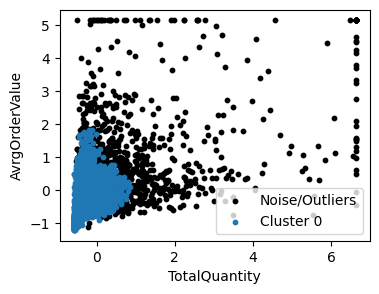

In [32]:
# Training DBSCAN model, eps value, min_samples value, using function defined in the functions.py
cust_dbscan = dbscan_model(cust_norm_clip_stndrd, 0.2, 10)

scatter_plot(cust_dbscan[['TotalQuantity','AvrgOrderValue']], cust_dbscan['dbscan_labels'])

## Clustering with DBSCAN - with less features

At the conclusion is shown that less features for this model **does not** work better.

DBSCAN silhouette coefficient:  0.6454
DBSCAN Calinski-Harabasz Index:  1835.1619
DBSCAN Davies-Bouldin Index:  1.2096
Label: -1, Percentage total customers: 14.76%
Label: 0, Percentage total customers: 85.24%


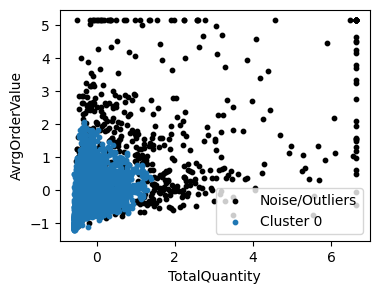

In [33]:
# Training DBSCAN model, eps value, min_samples value, using function defined in the functions.py
cust_dbscan2 = dbscan_model(cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']], 0.2, 10)

scatter_plot(cust_dbscan2[['TotalQuantity','AvrgOrderValue']], cust_dbscan2['dbscan_labels'])

## Clustering with DBSCAN - dimensionality reduction

DBSCAN silhouette coefficient:  0.7126
DBSCAN Calinski-Harabasz Index:  1413.3279
DBSCAN Davies-Bouldin Index:  1.2478
Label: -1, Percentage total customers: 11.82%
Label: 0, Percentage total customers: 88.18%


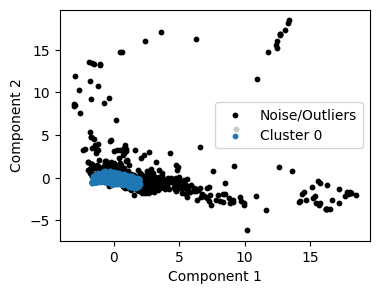

In [34]:
# Training DBSCAN model with the isomap applied, eps value, min_samples value, using function defined in the functions.py
cust_dbscan3 = dbscan_model(cust_norm_clip_stndrd_reduced, 0.2, 20)

scatter_plot(cust_dbscan3[['Component 1','Component 2']], cust_dbscan3['dbscan_labels'],'Component 1','Component 2')

## Clustering with HDBSCAN

HDBSCAN silhouette coefficient:  0.7272
HDBSCAN Calinski-Harabasz Index:  1046.6115
HDBSCAN Davies-Bouldin Index:  0.9566
Label: -1, Percentage total customers: 4.52%
Label: 1, Percentage total customers: 94.84%
Label: 0, Percentage total customers: 0.28%
Label: 2, Percentage total customers: 0.36%


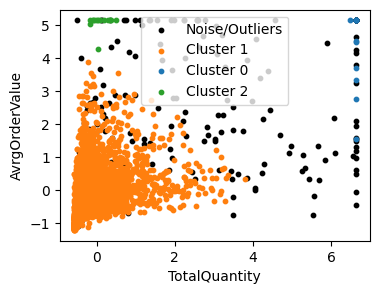

In [35]:
# Training HDBSCAN model, min_cluster_size=10, using function defined in the functions.py
cust_hdbscan = hdbscan_model(cust_norm_clip_stndrd, 10)

scatter_plot(cust_hdbscan[['TotalQuantity','AvrgOrderValue']], cust_hdbscan['hdbscan_labels'])

## Clustering with HDBSCAN - dimensionality reduction

HDBSCAN silhouette coefficient:  0.8704
HDBSCAN Calinski-Harabasz Index:  1592.1876
HDBSCAN Davies-Bouldin Index:  1.1154
Label: 0, Percentage total customers: 0.28%
Label: 3, Percentage total customers: 98.24%
Label: 2, Percentage total customers: 0.77%
Label: -1, Percentage total customers: 0.46%
Label: 1, Percentage total customers: 0.26%


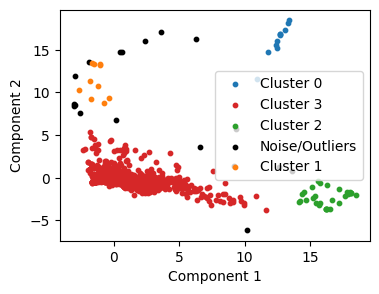

In [36]:
# Training HDBSCAN model with isomap applied, min_cluster_size=10, using function defined in the functions.py
cust_hdbscan2 = hdbscan_model(cust_norm_clip_stndrd_reduced, 10)

scatter_plot(cust_hdbscan2[['Component 1','Component 2']], cust_hdbscan2['hdbscan_labels'],'Component 1','Component 2')

## Gaussian Mixture clustering

GaussianMixture silhouette coefficient:  0.5826
GaussianMixture Calinski-Harabasz Index:  1836.2138
GaussianMixture Davies-Bouldin Index:  1.1878
Label: 1, Percentage total customers: 50.32%
Label: 3, Percentage total customers: 4.03%
Label: 2, Percentage total customers: 38.68%
Label: 0, Percentage total customers: 6.97%


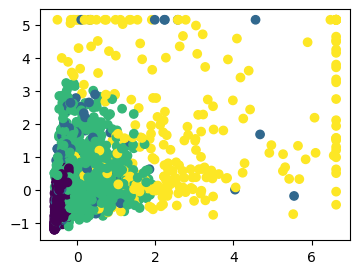

In [37]:
# Choosing 4 clusters, using function defined in the functions.py
cust_gm = gm_model(cust_norm_clip_stndrd, 4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_gm['TotalQuantity'], y=cust_gm['AvrgOrderValue'], c=cust_gm['gm_labels'])
plt.show()

## Gaussian Mixture clustering - Less features

GaussianMixture silhouette coefficient:  0.5159
GaussianMixture Calinski-Harabasz Index:  1831.1301
GaussianMixture Davies-Bouldin Index:  1.2655
Label: 2, Percentage total customers: 32.86%
Label: 0, Percentage total customers: 43.02%
Label: 3, Percentage total customers: 5.92%
Label: 1, Percentage total customers: 18.2%


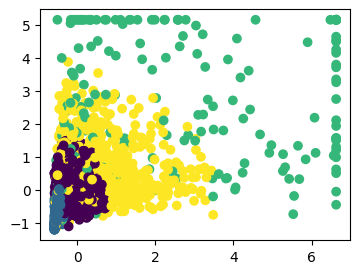

In [38]:
# Choosing 4 clusters, dataframe with 3 features, using function defined in the functions.py
cust_gm2 = gm_model(cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']], 4)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_gm2['TotalQuantity'], y=cust_gm2['AvrgOrderValue'], c=cust_gm2['gm_labels'])
plt.show()

## Gaussian Mixture clustering - dimensionality reduction + 2 clusters

GaussianMixture silhouette coefficient:  0.7077
GaussianMixture Calinski-Harabasz Index:  1485.3141
GaussianMixture Davies-Bouldin Index:  1.1887
Label: 1, Percentage total customers: 87.18%
Label: 0, Percentage total customers: 12.82%


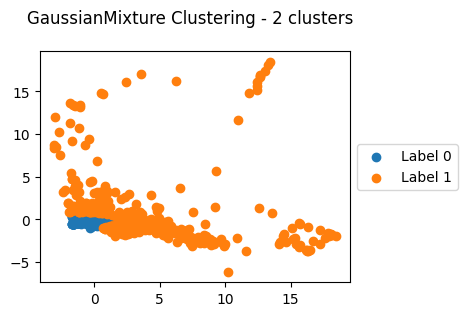

In [39]:
# Choosing 4 clusters, dataframe with isomap applied, using function defined in the functions.py
cust_gm5 = gm_model(cust_norm_clip_stndrd_reduced, 2)

# Plotting the results
label_names = {0: 'Label 0', 1: 'Label 1'}

# Plotting the results
plt.figure(figsize=(4, 3))
for label, name in label_names.items():
    plt.scatter(x=cust_gm5[cust_gm5['gm_labels'] == label]['Component 1'], 
                y=cust_gm5[cust_gm5['gm_labels'] == label]['Component 2'], 
                label=name)
plt.suptitle("GaussianMixture Clustering - 2 clusters", y=1.02)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig("../images/gm-2.png", bbox_inches='tight')
plt.show()

## Gaussian Mixture clustering - dimensionality reduction + 4 clusters

GaussianMixture silhouette coefficient:  0.6673
GaussianMixture Calinski-Harabasz Index:  1433.2679
GaussianMixture Davies-Bouldin Index:  1.4324
Label: 2, Percentage total customers: 9.27%
Label: 3, Percentage total customers: 51.47%
Label: 1, Percentage total customers: 2.78%
Label: 0, Percentage total customers: 36.48%


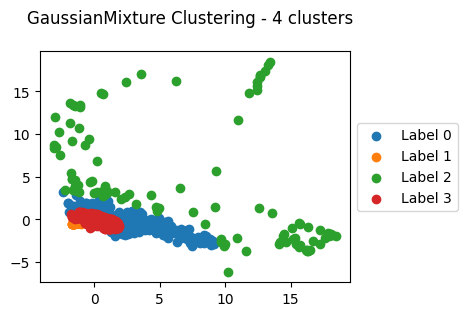

In [40]:
# Choosing 4 clusters, dataframe with isomap applied, using function defined in the functions.py
cust_gm3 = gm_model(cust_norm_clip_stndrd_reduced, 4)

# Plotting the results
label_names = {0: 'Label 0', 1: 'Label 1', 2: 'Label 2', 3: 'Label 3'}

# Plotting the results
plt.figure(figsize=(4, 3))
for label, name in label_names.items():
    plt.scatter(x=cust_gm3[cust_gm3['gm_labels'] == label]['Component 1'], 
                y=cust_gm3[cust_gm3['gm_labels'] == label]['Component 2'], 
                label=name)
plt.suptitle("GaussianMixture Clustering - 4 clusters", y=1.02)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig("../images/gm-4.png", bbox_inches='tight')
plt.show()

## Gaussian Mixture clustering - dimensionality reduction + 6 clusters

GaussianMixture silhouette coefficient:  0.7345
GaussianMixture Calinski-Harabasz Index:  3136.9728
GaussianMixture Davies-Bouldin Index:  0.9181
Label: 2, Percentage total customers: 52.44%
Label: 3, Percentage total customers: 9.01%
Label: 4, Percentage total customers: 0.69%
Label: 0, Percentage total customers: 35.72%
Label: 1, Percentage total customers: 0.77%
Label: 5, Percentage total customers: 1.38%


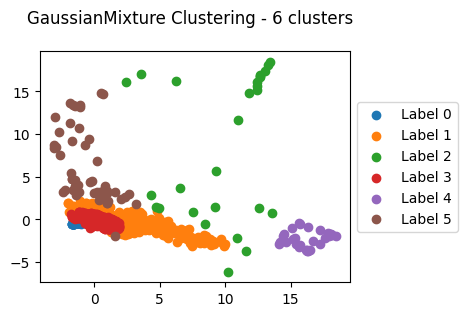

In [41]:
# Choosing 6 clusters, dataframe with isomap applied, using function defined in the functions.py
cust_gm4 = gm_model(cust_norm_clip_stndrd_reduced, 6)

# Plotting the results
label_names = {0: 'Label 0', 1: 'Label 1', 2: 'Label 2', 3: 'Label 3', 4: 'Label 4', 5: 'Label 5'}

# Plotting the results
plt.figure(figsize=(4, 3))
for label, name in label_names.items():
    plt.scatter(x=cust_gm4[cust_gm4['gm_labels'] == label]['Component 1'], 
                y=cust_gm4[cust_gm4['gm_labels'] == label]['Component 2'], 
                label=name)
plt.suptitle("GaussianMixture Clustering - 6 clusters", y=1.02)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig("../images/gm-6.png", bbox_inches='tight')
plt.show()

## Mean shift clustering

MeanShift silhouette coefficient:  0.8445
MeanShift Calinski-Harabasz Index:  1399.2164
MeanShift Davies-Bouldin Index:  0.6837
Label: 1, Percentage total customers: 98.75%
Label: 0, Percentage total customers: 1.25%


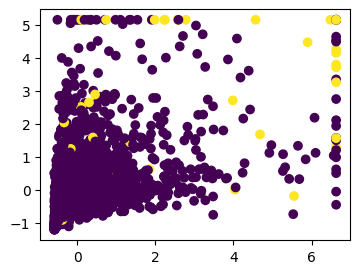

In [42]:
# Function, with bandwidth=5 for the clustering defined in the functions.py
cust_mshift = mshift_model(cust_norm_clip_stndrd,5)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_mshift['TotalQuantity'], y=cust_mshift['AvrgOrderValue'], c=cust_mshift['mshift_labels'])
plt.show()

## Mean shift clustering - dimensionality reduction

MeanShift silhouette coefficient:  0.8657
MeanShift Calinski-Harabasz Index:  2866.5570
MeanShift Davies-Bouldin Index:  0.3970
Label: 3, Percentage total customers: 97.73%
Label: 0, Percentage total customers: 1.33%
Label: 1, Percentage total customers: 0.61%
Label: 2, Percentage total customers: 0.33%


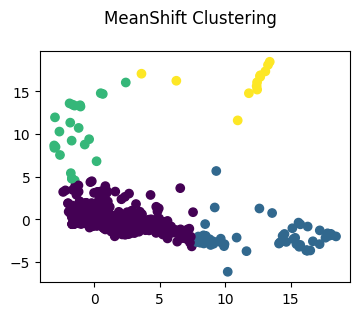

In [43]:
# Function, with bandwidth=5 and isomap applied for the clustering defined in the functions.py
cust_mshift2 = mshift_model(cust_norm_clip_stndrd_reduced,5)

# Plotting the results
plt.figure(figsize=(4, 3))
plt.scatter(x=cust_mshift2['Component 1'], y=cust_mshift2['Component 2'], c=cust_mshift2['mshift_labels'])
plt.suptitle("MeanShift Clustering", y=1.02)
plt.savefig("../images/mshift.png", bbox_inches='tight')
plt.show()

In [44]:
# update

Firstly, the test scores work the best to compare models of the same type. By looking at these scores, it is evident if the models perform better with more or less features:
- Kmeans: model with **more** features better
- DBSCAN: model with **more** features better
- HDBSCAN (this I didn't check, cause I was not satisfied with the model)
- Gaussian Mixture: model with **less** features better
- Mean Shift: model with **more** features better 

# Model comparison conclusions

I will be using the Gaussian Mixture model with 4 clusters, with the data with dimensionality reduction.

In [45]:
# elaborate further

# Renaming labels for clarity

I see from the following that my 4 clusters are hierarchical on the order value and quantities.
I am gonna sort the label number according to that for clarity.

In [52]:
# Adding the labels to the original dataframe of the customers (before any normalization/ scaling etc)
cust_clust = pd.merge(cust, cust_gm3['gm_labels'], left_index=True, right_index=True)

cust_clust.reset_index(inplace=True)
cust_clust.rename(columns={'index': 'CustomerID','gm_labels':'Label'}, inplace=True)

In [53]:
cust_clust.groupby('Label')[['AvrgQuantity','AvrgOrderValue']].describe()

AvrgQuantity                                                             \
             count         mean          std   min      25%     50%       75%   
Label                                                                           
0            363.0    32.154738    28.053675  2.15  11.6000   20.04   48.1350   
1           2016.0     8.496240     5.231406  1.00   4.2475    7.90   11.4325   
2            109.0  1301.644220  7524.358739  3.05  91.3400  167.81  354.4800   
3           1429.0    13.454696     9.622134  1.62   7.5000   10.83   15.7100   

                AvrgOrderValue                                             \
            max          count         mean           std    min      25%   
Label                                                                       
0        144.00          363.0   654.187906    429.397265  41.76  384.550   
1         30.67         2016.0   225.157406    128.991914   3.75  134.615   
2      74215.00          109.0  3128.569083  11927.603058  90.48  562.860   
3         67.07         1429.0   416.785332    253.190473  26.00  264.360   

                                  
          50%      75%       max  
Label                             
0      534.57   813.33   2630.30  
1      195.55   296.64    799.05  
2      854.67  1648.41  92768.75  
3      365.48   478.89   2304.70

In [54]:
cust_clust.groupby('Label')[['TotalQuantity','TotalValue','AvrgQuantity','AvrgOrderValue']].mean()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
Label,,,,
0,2915.848485,5517.582452,32.154738,654.187906
1,202.634425,373.868181,8.496240,225.157406
2,12604.449541,25121.879725,1301.644220,3128.569083
3,975.142057,1703.063381,13.454696,416.785332


In [55]:
cust_clust['Label'] = cust_clust.Label.map({1:0,3:1,0:2,2:3})

In [56]:
cust_clust.groupby('Label')[['TotalQuantity','TotalValue','AvrgQuantity','AvrgOrderValue']].mean()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
Label,,,,
0,202.634425,373.868181,8.496240,225.157406
1,975.142057,1703.063381,13.454696,416.785332
2,2915.848485,5517.582452,32.154738,654.187906
3,12604.449541,25121.879725,1301.644220,3128.569083


# Saving datasets with clusters

In [58]:
# Saving the dataset that is filtered: Only actual products (good), only UK, dropping NaN customerID (needs to be solved)
df_fltrd_clust = pd.merge(df_fltrd, cust_clust[['CustomerID', 'Label']], on='CustomerID')

df_fltrd_clust.to_csv('../data/data_filtered_with_clusters.csv', index=False)